<a href="https://colab.research.google.com/github/xxxnmxhj00/Deep-Learning/blob/main/Faster_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two-Stage Detector인 Faster R-CNN으로 객체 탐지

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# 데이터 불러오기

## dataset 다운로드
- AI HUB [항만 구조물 영상](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=realm&dataSetSn=199) 샘플데이터 './원천데이터/bbox/ship/fishing_boat_56''와 './라벨링데이터/bbox/ship/fishing_boat_56' 사용

In [ ]:
!pip install gdown
!gdown --id 13HNXVppR9BOWuwgMRFoHlnCL__LZAp0z --output /content/ship.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=13HNXVppR9BOWuwgMRFoHlnCL__LZAp0z
From (redirected): https://drive.google.com/uc?id=13HNXVppR9BOWuwgMRFoHlnCL__LZAp0z&confirm=t&uuid=898c3004-a3a1-41c1-be0d-f24fe56b3db5
To: /content/ship.zip
100% 260M/260M [00:05<00:00, 44.5MB/s]


In [ ]:
!unzip -qq ship.zip
!rm ship.zip

## 바운딩 박스 도식화

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup

- glob 패키지를 이용해 데이터셋을 로드.
- 추가로 sorted 함수를 사용해 img_list에 있는 파일의 id 순서와 annot_list에 있는 파일의 id 순서가 같도록 정렬

In [ ]:
img_list = sorted(glob.glob('ship/images/*'))
annot_list = sorted(glob.glob('ship/annotations/*'))

In [ ]:
print(len(img_list))
print(len(annot_list))

650
650


In [ ]:
print(img_list[:10])
print(annot_list[:10])

['ship/images/fishing_boat_b_56_0000002.jpg', 'ship/images/fishing_boat_b_56_0000007.jpg', 'ship/images/fishing_boat_b_56_0000008.jpg', 'ship/images/fishing_boat_b_56_0000011.jpg', 'ship/images/fishing_boat_b_56_0000013.jpg', 'ship/images/fishing_boat_b_56_0000046.jpg', 'ship/images/fishing_boat_b_56_0000103.jpg', 'ship/images/fishing_boat_b_56_0000113.jpg', 'ship/images/fishing_boat_b_56_0000118.jpg', 'ship/images/fishing_boat_b_56_0000130.jpg']
['ship/annotations/fishing_boat_b_56_0000002.xml', 'ship/annotations/fishing_boat_b_56_0000007.xml', 'ship/annotations/fishing_boat_b_56_0000008.xml', 'ship/annotations/fishing_boat_b_56_0000011.xml', 'ship/annotations/fishing_boat_b_56_0000013.xml', 'ship/annotations/fishing_boat_b_56_0000046.xml', 'ship/annotations/fishing_boat_b_56_0000103.xml', 'ship/annotations/fishing_boat_b_56_0000113.xml', 'ship/annotations/fishing_boat_b_56_0000118.xml', 'ship/annotations/fishing_boat_b_56_0000130.xml']


-  파일의 id 순서가 동일한 것 확인

- 잘못된 이미지-라벨 삭제

In [ ]:
name_lst = []
for imgname in img_list:
    name_lst.append(imgname.split('/')[-1][:-4])


In [ ]:
for annotname in annot_list:
    name = annotname.split('/')[-1][:-4]
    if name not in name_lst:
        print(annotname)
        os.remove(annotname)

ship/annotations/fishing_boat_b_56_0022200.xml
ship/annotations/fishing_boat_b_56_0022201.xml
ship/annotations/fishing_boat_b_56_0022202.xml
ship/annotations/fishing_boat_b_56_0022203.xml
ship/annotations/fishing_boat_b_56_0022204.xml
ship/annotations/fishing_boat_b_56_0022205.xml
ship/annotations/fishing_boat_b_56_0022206.xml
ship/annotations/fishing_boat_b_56_0022207.xml
ship/annotations/fishing_boat_b_56_0022208.xml


In [ ]:
name_lst = []
for imgname in annot_list:
    name_lst.append(imgname.split('/')[-1][:-4])

In [ ]:
for imgname in img_list:
    name = imgname.split('/')[-1][:-4]
    if name not in name_lst:
        print(imgname)
        os.remove(imgname)

ship/images/fishing_boat_b_56_0022220.jpg
ship/images/fishing_boat_b_56_0022221.jpg
ship/images/fishing_boat_b_56_0022222.jpg
ship/images/fishing_boat_b_56_0022223.jpg
ship/images/fishing_boat_b_56_0022224.jpg
ship/images/fishing_boat_b_56_0022225.jpg
ship/images/fishing_boat_b_56_0022226.jpg
ship/images/fishing_boat_b_56_0022227.jpg
ship/images/fishing_boat_b_56_0022228.jpg


In [ ]:
img_list = sorted(glob.glob('ship/images/*'))
annot_list = sorted(glob.glob('ship/annotations/*'))
print(len(img_list))
print(len(annot_list))

641
641


### 바운딩 박스 시각화를 위한 함수를 정의

In [ ]:
def generate_box(obj): # xmin, ymin, xmax, ymax 값을 반환
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

def generate_label(obj): # 객체에 따른 라벨 반환
    if obj.find('name').text == "fishing_boat":
        return 1
    elif obj.find('name').text == "Unknown":
        return 2
    return 0

In [ ]:
def generate_target(file): #  generate_box와 generate_label를 각각 호출하여 반환된 값을 딕셔너리에 저장해 반환하는 함수
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser") #  html.parser를 이용해 annotations 파일에 있는 내용들을 불러와 타겟의 바운딩 박스와 라벨을 추출
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

In [ ]:
def plot_image(img_path, annotation):
    img = mpimg.imread(img_path)
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='y',facecolor='none')
        else :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')
        ax.add_patch(rect)
    plt.show()

/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


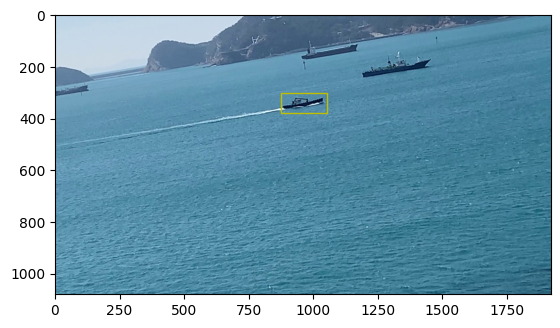

In [ ]:
bbox = generate_target(annot_list[100])
plot_image(img_list[100], bbox)

# 데이터 전처리
- 이미지 augmentation에 사용되는 `torchvision.transforms`와 `albumentations` 모듈
- `torchvision.transforms`는 파이토치에서 공식적으로 제공하는 모듈
- `albumentations`는 `OpenCV`와 같은 오픈 소스 컴퓨터 비젼 라이브러리를 최적화 하였기에 다른 라이브러리보다 더 빠른 처리 속도 및 기타 기능을 제공하는 모듈
- augmentation은 이미지 뿐만 아니라 바운딩 박스까지 변형을 주어야 하는데, `torchvision.transforms`에는 해당 기능을 제공하지 않음 때문에 `albumentations`를 활용해 바운딩 박스 augmentation을 실습.

## Torchvision Transforms
- `torchvision.transforms`을 실습하기 위해 `TorchvisionDataset` 클래스를 먼저 정의
- `TorchvisionDataset` 클래스는`__getitem__` 메소드를 통해 image를 불러온 다음 데이터 augmentation을 진행, `transform` 파라미터에 저장돼 있는 augmentation 규칙에 따라 augmentation이 진행.

In [ ]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

class TorchvisionShipDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("/content/ship/test_annotations/", file_label)
        else:
            label_path = os.path.join("/content/ship/annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            img = self.transform(img)

        total_time = (time.time() - start_t)

        return img, target, total_time

In [ ]:
torchvision_transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize 함수를 통해 이미지 크기를 조정
    transforms.RandomCrop(224), # RandomCrop 함수를 통해 이미지 자름
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # ColorJitter 함수는 밝기, 대비, 채도, 색조 등을 임의로 바꾸는 기능
    transforms.RandomHorizontalFlip(p = 1),# RandomHorizontalFlip은 정의한 p의 확률로 좌우반전
    transforms.ToTensor(), # 텐서 자료형으로 변환
])

In [ ]:
# plot_image_from_output함수는 torch.Tensor로 변환된 이미지를 시각화
def plot_image_from_output(img, annotation):

    img = img.permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='y',facecolor='none')
        else :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


transforms 적용 전


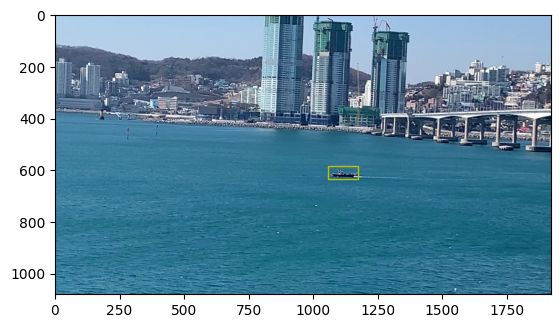

{'boxes': tensor([[1056.,  582., 1174.,  633.]]), 'labels': tensor([1])}


In [ ]:
only_totensor = transforms.Compose([transforms.ToTensor()])

torchvision_dataset_no_transform = TorchvisionShipDataset(
    path = '/content/ship/images/',
    transform = only_totensor
)

img, annot, transform_time = torchvision_dataset_no_transform[5]
print('transforms 적용 전')
plot_image_from_output(img, annot)
print(annot)

transforms 적용 후


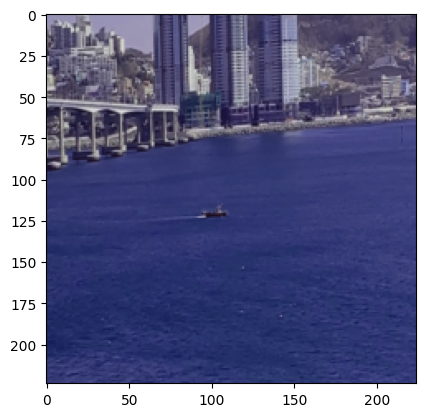

{'boxes': tensor([[1056.,  582., 1174.,  633.]]), 'labels': tensor([1])}


In [ ]:
torchvision_dataset = TorchvisionShipDataset(
    path = '/content/ship/images/',
    transform = torchvision_transform
)

img, annot, transform_time = torchvision_dataset[5]

print('transforms 적용 후')
plot_image_from_output(img, annot)
print(annot)

- 바운딩 박스의 범위가 이미지 크기를 벗어났기 때문에 이미지에서 확인 불가능

## Albumentations
- `torchvision`과 사용 방법이 비슷

In [ ]:
class AlbumentationsDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("/content/ship/test_annotations/", file_label)
        else:
            label_path = os.path.join("/content/ship/annotations/", file_label)

        # Read an image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            total_time = (time.time() - start_t)
            image = augmented['image']


        return image, target, total_time

In [ ]:
albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300),
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    albumentations.HorizontalFlip(p=1),
    albumentations.pytorch.ToTensorV2(), # 텐서 자료형으로 변환
])

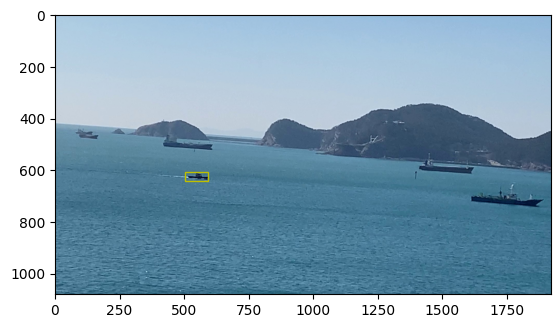

{'boxes': tensor([[504., 606., 594., 641.]]), 'labels': tensor([1])}


In [ ]:
# 변경 전
img, annot, transform_time = torchvision_dataset_no_transform[0]
plot_image_from_output(img, annot)
print(annot)

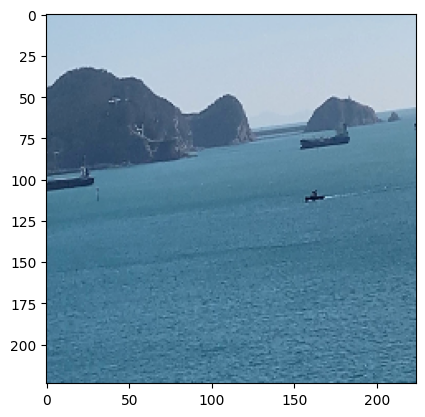

{'boxes': tensor([[504., 606., 594., 641.]]), 'labels': tensor([1])}


In [ ]:
# 변경 후
albumentation_dataset = AlbumentationsDataset(
    path = '/content/ship/images/',
    transform = albumentations_transform
)

img, annot, transform_time = albumentation_dataset[0]
plot_image_from_output(img, annot)
print(annot)

- `torchvision.transforms`과 마찬가지로 이미지 변환이 이루어 졌지만, 바운딩 박스는 변하지 않음

### 바운딩 박스 Augmentation
- 객체 탐지 모델 구축에 사용되는 이미지에 대한 augmentation 진행 시, 이미지 변환 뿐만 아니라 그에 따른 바운딩 박스 변환 또한 함께 진행해주어야 함.
- `Albumentations`에서 제공하는 Compose 함수에 있는 `bbox_params` 파라미터를 활용하면 바운딩 박스 augmentation이 가능

In [ ]:
class BboxAugmentationDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("/content/ship/test_annotations/", file_label)
        else:
            label_path = os.path.join("/content/ship/annotations/", file_label)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'],
                                         labels = target['labels'])
            image = transformed['image']
            target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}


        return image, target

In [ ]:
bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.pytorch.ToTensorV2()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

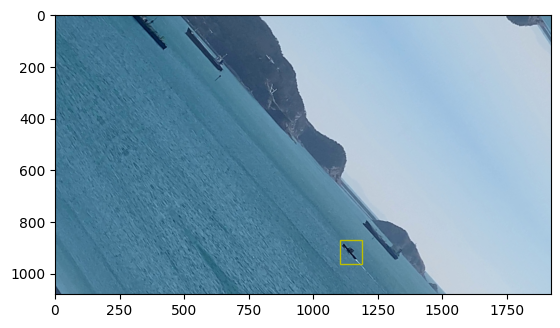

{'boxes': [(1104.3785055130115, 869.7171336496144, 1187.1757836827867, 962.2937772953035)], 'labels': [tensor(1)]}


In [ ]:
bbox_transform_dataset = BboxAugmentationDataset(
    path = '/content/ship/images/',
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)
print(annot)

# 데이터 분리

In [ ]:
print(len(os.listdir('/content/ship/annotations')))
print(len(os.listdir('/content/ship/images')))

641
641


In [ ]:
%cd /content/ship/

/content/ship


In [ ]:
!mkdir test_images
!mkdir test_annotations

In [ ]:
import random
random.seed(1234)
img_len = len(os.listdir('/content/ship/images'))
idx = random.sample(range(img_len), 100)
print(len(idx))
print(idx[:10])

100
[451, 119, 7, 92, 596, 35, 85, 100, 363, 242]


In [ ]:
import numpy as np
import shutil

for img in np.array(sorted(os.listdir('/content/ship/images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('/content/ship/annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

In [ ]:
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

541
541
100
100


이미지 분류 문제에서는 훈련용 시험용 데이터를 나눈 후 이미지 개수만 확인하면 되겠지만, 객체 탐지 문제에서는 각 클래스 별로 몇 개의 객체가 데이터셋 내부에 존재하는지 확인하는 작업이 필요

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
from collections import Counter

def get_num_objects_for_each_class(dataset):

    total_labels = []
    for img, annot in tqdm(dataset, position = 0, leave = True):
        total_labels += [int(i) for i in annot['labels']]

    return Counter(total_labels)

train_data =  BboxAugmentationDataset(
    path = '/content/ship/images/'
)

test_data =  BboxAugmentationDataset(
    path = '/content/ship/test_images/'
)

train_objects = get_num_objects_for_each_class(train_data)
test_objects = get_num_objects_for_each_class(test_data)

print('\n train 데이터에 있는 객체', train_objects)
print('\n test 데이터에 있는 객체', test_objects)

  0%|          | 0/541 [00:00<?, ?it/s]

/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


  0%|          | 0/100 [00:00<?, ?it/s]


 train 데이터에 있는 객체 Counter({1: 541})

 test 데이터에 있는 객체 Counter({1: 100})


# 데이터셋 클래스 정의

In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [ ]:
class ShipDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))

    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("/content/ship/test_annotations/", file_label)
        else:
            label_path = os.path.join("/content/ship/annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

# transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
data_transform = transforms.Compose([
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = ShipDataset(data_transform,'/content/ship/images/')
test_dataset = ShipDataset(data_transform,'/content/ship/test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

# 모델 불러오기
- `torchvision.models.detection`에서는 Faster R-CNN API(`torchvision.models.detection.fasterrcnn_resnet50_fpn`)를 제공하고 있어 쉽게 구현이 가능
- COCO 데이터셋을 ResNet50으로 pre-trained한 모델을 제공하고 있으며, `pretrained=True/False`로 설정할 수 있다.

- 이후 모델을 불러올 때는 `num_classes`에 원하는 클래스 개수를 설정하고 모델을 사용하면 됨.
- Faster R-CNN 사용 시 주의할 점은 background 클래스를 포함한 개수를 `num_classes`에 명시(즉, 실제 데이터셋의 클래스 개수에 1개를 늘려 background 클래스를 추가 (num_classes + 1))

In [ ]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
# 실제 데이터셋의 클래스 개수에 1개를 늘려 background 클래스를 추가 (num_classes + 1)
num_classes = len(train_objects.keys()) + 1
num_classes

2

# 전이 학습
- Ship Detection에 전이 학습을 실시해 보겠습니다. Ship Detection 데이터셋은 1개의 클래스로 이루어져 있지만 background 클래스를 포함하여 num_classes를 2로 설정한 후 모델을 로드

In [ ]:
model = get_model_instance_segmentation(num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 170MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

위의 출력되는 결과를 통해 Fastser R-CNN이 어떤 layer들로 구성확인.    
이 때, GPU 사용 가능 여부는 `torch.cuda.is_available()`를 통해 확인.

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in tqdm(range(num_epochs)):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')
print('----------------------train end--------------------------')

----------------------train start--------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

epoch : 1, Loss : 19.842485427856445, time : 154.47135972976685
epoch : 2, Loss : 14.406570434570312, time : 159.0429756641388
epoch : 3, Loss : 11.96563720703125, time : 158.9631118774414
epoch : 4, Loss : 10.841904640197754, time : 159.63514280319214
epoch : 5, Loss : 10.199387550354004, time : 159.54900598526
epoch : 6, Loss : 9.59838581085205, time : 159.3624804019928
epoch : 7, Loss : 8.267168045043945, time : 160.77010130882263
epoch : 8, Loss : 7.594256401062012, time : 160.81192541122437
epoch : 9, Loss : 7.342068195343018, time : 161.95576095581055
epoch : 10, Loss : 7.108903408050537, time : 160.3717737197876
----------------------train end--------------------------


In [ ]:
torch.save(model.state_dict(),f'FasterR-CNN_model_{num_epochs}.pt') # torch.save를 이용하여 학습된 가중치 저장

In [ ]:
model.load_state_dict(torch.load(f'FasterR-CNN_model_{num_epochs}.pt'))

<ipython-input-54-c3b94a3eade0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'FasterR-CNN_model_{num_epochs}.pt'))


<All keys matched successfully>

In [ ]:
from google.colab import files
files.download(f'FasterR-CNN_model_{num_epochs}.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 예측

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


[{'boxes': tensor([[1057.3969,  586.8244, 1184.8552,  640.8735]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9158], device='cuda:0')}, {'boxes': tensor([[739.3973, 519.1239, 860.3186, 579.3576]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9908], device='cuda:0')}]


In [ ]:
# plot_image_from_output함수는 torch.Tensor로 변환된 이미지를 시각화
def plot_image_from_output(img, annotation):
    img = img.permute(1,2,0)
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    for idx in range(len(annotation["boxes"])):
        print(annotation["boxes"][idx].to(torch.device('cpu')))
        xmin, ymin, xmax, ymax = annotation["boxes"][idx].to(torch.device('cpu'))
        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),
                                     linewidth=1,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,
                                     edgecolor='y',facecolor='none')
        else :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,
                                     edgecolor='orange',facecolor='none')

        ax.add_patch(rect)
    plt.show()

In [ ]:
_idx = 1
imgs[_idx]

tensor([[[0.3137, 0.2863, 0.2471,  ..., 0.5569, 0.5569, 0.5569],
         [0.3569, 0.3373, 0.2980,  ..., 0.5569, 0.5569, 0.5569],
         [0.4275, 0.4431, 0.4314,  ..., 0.5569, 0.5569, 0.5569],
         ...,
         [0.2471, 0.2471, 0.2510,  ..., 0.1608, 0.1608, 0.1647],
         [0.2235, 0.2235, 0.2314,  ..., 0.1608, 0.1608, 0.1647],
         [0.2118, 0.2078, 0.2118,  ..., 0.1608, 0.1608, 0.1608]],

        [[0.4157, 0.3882, 0.3490,  ..., 0.7294, 0.7294, 0.7294],
         [0.4588, 0.4392, 0.4000,  ..., 0.7294, 0.7294, 0.7294],
         [0.5294, 0.5451, 0.5333,  ..., 0.7294, 0.7294, 0.7294],
         ...,
         [0.4431, 0.4431, 0.4471,  ..., 0.4353, 0.4353, 0.4392],
         [0.4196, 0.4196, 0.4275,  ..., 0.4353, 0.4353, 0.4392],
         [0.4078, 0.4039, 0.4078,  ..., 0.4353, 0.4353, 0.4353]],

        [[0.4745, 0.4471, 0.4078,  ..., 0.9137, 0.9137, 0.9137],
         [0.5176, 0.4980, 0.4588,  ..., 0.9137, 0.9137, 0.9137],
         [0.5882, 0.6039, 0.5922,  ..., 0.9137, 0.9137, 0.

In [ ]:
annotations[_idx]

{'boxes': tensor([[742., 518., 871., 573.]]), 'labels': tensor([1])}

Target :  tensor([1])
tensor([742., 518., 871., 573.])


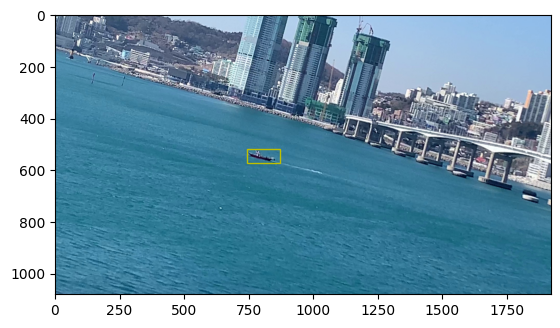

Prediction :  tensor([1], device='cuda:0')
tensor([739.3973, 519.1239, 860.3186, 579.3576])


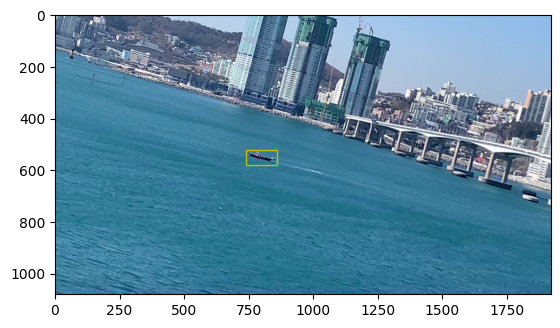

In [ ]:
_idx = 1
img = imgs[_idx].to(torch.device('cpu'))
print("Target : ", annotations[_idx]['labels'])
org_boxes = annotations[_idx]['boxes'].to(torch.device('cpu'))
org_labels = annotations[_idx]['labels'].to(torch.device('cpu'))
org_cpu_tensor={'boxes': org_boxes,'labels': org_labels}
plot_image_from_output(img, org_cpu_tensor)

print("Prediction : ", pred[_idx]['labels'])
pred_boxes = pred[_idx]['boxes'].to(torch.device('cpu'))
pred_labels = pred[_idx]['labels'].to(torch.device('cpu'))
pred_cpu_tensor={'boxes': pred_boxes, 'labels' : pred_labels}

plot_image_from_output(img, pred_cpu_tensor)

예측 결과 평가. 먼저 모든 시험 데이터에 대한 예측 결과와 실제 label을 각각 preds_adj_all, annot_all에 저장

In [ ]:
labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
'''
mAP 계산 함수
'''

def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i] # predict
        # pred_boxes = output['boxes']
        # pred_scores = output['scores']
        # pred_labels = output['labels']

        true_positives = torch.zeros(output['boxes'].shape[0])   # 예측 객체 개수

        annotations = targets[sample_i]  # actual
        target_labels = annotations['labels'] if len(annotations) else []
        if len(annotations):    # len(annotations) = 3
            detected_boxes = []
            target_boxes = annotations['boxes']

            for pred_i, (pred_box, pred_label) in enumerate(zip(output['boxes'], output['labels'])): # 예측값에 대해서..

                # If targets are found break
                if len(detected_boxes) == len(target_labels): # annotations -> target_labels
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)   # box_index : 실제 어떤 바운딩 박스랑 IoU 가 가장 높은지 index
                if iou >= iou_threshold and box_index not in detected_boxes: # iou만 맞으면 통과?
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]  # 예측된거랑 실제랑 매핑해서 하나씩 index 채움
        batch_metrics.append([true_positives, output['scores'], output['labels']])
    return batch_metrics

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = torch.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = torch.unique(target_cls)   # 2가 거의 예측안됨

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in unique_classes:
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = torch.cumsum(1 - tp[i],-1)
            tpc = torch.cumsum(tp[i],-1)

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = torch.tensor(np.array(p)), torch.tensor(np.array(r)), torch.tensor(np.array(ap))
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                           iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
# 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels,
                                                   torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.9210896614124948
AP : tensor([0.9211], dtype=torch.float64)
